# Text analysis

In this notebook, I'll build a taxt analysis tool based on the PubMed database, downloaded from ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/ .

This network is based on ... 
Also, some information ... on GitHub. 
Below is the general architecture of script.



In [1]:
import time
from collections import namedtuple
import os
import numpy as np
import tensorflow as tf
import glob
import re

In [2]:
import re
import codecs
import logging
import multiprocessing
import pprint

In [3]:
import nltk
import gensim
import gensim.models.word2vec as w2v
from gensim import corpora
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

In [5]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/erimel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/erimel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

First we'll load the text file and convert it into integers for our network to use. Here I'm creating a couple dictionaries to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [6]:
#rootdir = '/home/erimel/project/Onco/articles.0-9A-B.txt/3_Biotech'
#maindir = '/home/erimel/project/Onco'
#print(rootdir)

In [7]:
rootdir = '/home/erimel/project/Onco/articles.C-H.txt/Cancer'
newdir = '/home/erimel/project/Onco/articles.C-H.txt/'
#print(rootdir)
os.chdir(rootdir)

In [8]:
#os.chdir(rootdir)

In [9]:
files = [f for f in os.listdir(rootdir)]

In [10]:
#text_file = [None]*1000
#raw_sentences = [None]*1000
#length_text = 0
text =""

In [11]:
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r  

In [12]:
files = list_files(newdir)
len(files)

319853

In [13]:
newfiles = []
for i in range(0, len(files)):
    if "Cancer" in files[i]:
        newfiles.append(files[i])
    elif "cancer" in files[i]:
        newfiles.append(files[i])

        

In [14]:
len(newfiles)

9984

In [15]:
#print(files)
#for i in range(0, 10):
#    print("Reading article '{0}'...".format(i))
#    with open(files[i], 'r') as f:
#        text = f.read()
#        text_file[i]=text
#        length_text += len(text_file[i])
#    print("Text is now {0} characters long".format((length_text)))

In [17]:
text =""
for i in range(0, len(newfiles)):
    with open(newfiles[i], 'r') as f:
        raw=f.read()
        text += "ArticleID" + " "
        text += str(i) + " "
        text += "ArticleNAME" + " "
        text += files[i] + " "      
        
        try:
            start = raw.index("==== Body")
            stop = raw.index("==== Refs")
            text += str(raw[start +1:stop -1])
        except:
            text += str(raw[1:])
               
        #text += f.read()
        #text_f = f.read()
        #text_test.append(text_f)
        text_file = text
        length_text = len(text_file)
    if i%1000 == 0:
        print("Reading article '{0}'...".format(i))
        print("Text is now {0} characters long".format((length_text)))

Reading article '0'...
Text is now 19253 characters long
Reading article '1000'...
Text is now 17279415 characters long
Reading article '2000'...
Text is now 42641366 characters long
Reading article '3000'...
Text is now 71503197 characters long
Reading article '4000'...
Text is now 104004754 characters long
Reading article '5000'...
Text is now 120185281 characters long
Reading article '6000'...
Text is now 148754615 characters long
Reading article '7000'...
Text is now 176276121 characters long
Reading article '8000'...
Text is now 199001244 characters long
Reading article '9000'...
Text is now 228439024 characters long


In [58]:
#for i in range(0, 10):
#    print("Reading article '{0}'...".format(i))
#    with open(files[i], 'r') as f:
#        text += f.read()
#        text_file = text
#        length_text = len(text_file)
#    print("Text is now {0} characters long".format((length_text)))

In [59]:
#print(text_file[1])

In [18]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [19]:
#for i in range(0, 10):
#    raw_sentences[i] = tokenizer.tokenize(text_file[i])

raw_sentences = tokenizer.tokenize(text_file)

In [20]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [21]:
#sentence where each word is tokenized
#sentences = []
#for i in range(0, 10):
#    for raw_sentence in raw_sentences[i]:
#        if len(raw_sentence) > 0:
#            sentences.append(sentence_to_wordlist(raw_sentence))
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))



In [22]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Some investigators reported that these critical recurrences were related to poor differentiation [4,7].
['Some', 'investigators', 'reported', 'that', 'these', 'critical', 'recurrences', 'were', 'related', 'to', 'poor', 'differentiation']


In [23]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 36,848,528 tokens


# Train Word2Vec



In [24]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 0

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

Let's check out the first 100 characters, make sure everything is peachy. According to the [American Book Review](http://americanbookreview.org/100bestlines.asp), this is the 6th best first line of a book ever.

And we can see the characters encoded as integers.

In [25]:
articles2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [26]:
articles2vec.build_vocab(sentences)
print(sentences[5])
print(len(sentences))
print(articles2vec)

['Some', 'investigators', 'reported', 'that', 'these', 'critical', 'recurrences', 'were', 'related', 'to', 'poor', 'differentiation']
1574309
Word2Vec(vocab=101919, size=300, alpha=0.025)


In [27]:
articles2vec.train(sentences, total_examples=articles2vec.corpus_count, epochs=articles2vec.iter)

183381940

In [29]:
os.chdir(newdir)
if not os.path.exists("trained"):
    os.makedirs("trained")

In [30]:
articles2vec.save(os.path.join("trained", "articles2vec.w2v"))

In [31]:
#how to visualize a dataset
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [32]:
all_word_vectors_matrix = articles2vec.wv.syn0 

In [ ]:
#Train t-SNE, this could take a minute or two...
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [137]:
all_word_vectors_matrix_2d

array([[ 48.05082703,  21.14950943],
       [ 16.2756176 , -62.57862091],
       [ 15.59880638, -28.05325699],
       ..., 
       [-14.24968147,  30.20368576],
       [ 35.5005722 ,  27.31178474],
       [-14.26500416,  20.150774  ]], dtype=float32)

In [98]:
#Plot the big picture
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[articles2vec.wv.vocab[word].index])
            for word in articles2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [113]:
points.head()

,word,x,y
0,ArticleID,-44.840473,66.297401
1,ArticleNAME,-44.881142,66.192368
2,home,-44.978134,65.947525
3,erimel,-45.259472,65.432915
4,project,-45.264847,65.326065


In [122]:
points.loc[points['word']=="gene"]

,word,x,y
2543,gene,34.133739,18.762928


In [133]:
points['word'][0]

'ArticleID'

In [100]:
sns.set_context("poster")

In [131]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(all_word_vectors_matrix[:viz_words, :])

In [143]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(len(all_word_vectors_matrix_2d)):
    plt.scatter(*all_word_vectors_matrix_2d[idx, :], color='steelblue')
    plt.annotate(points['word'][idx], (all_word_vectors_matrix_2d[idx, 0], all_word_vectors_matrix_2d[idx, 1]), alpha=0.7)

In [144]:
#points.plot.scatter("x", "y", s=10, figsize=(20, 12))

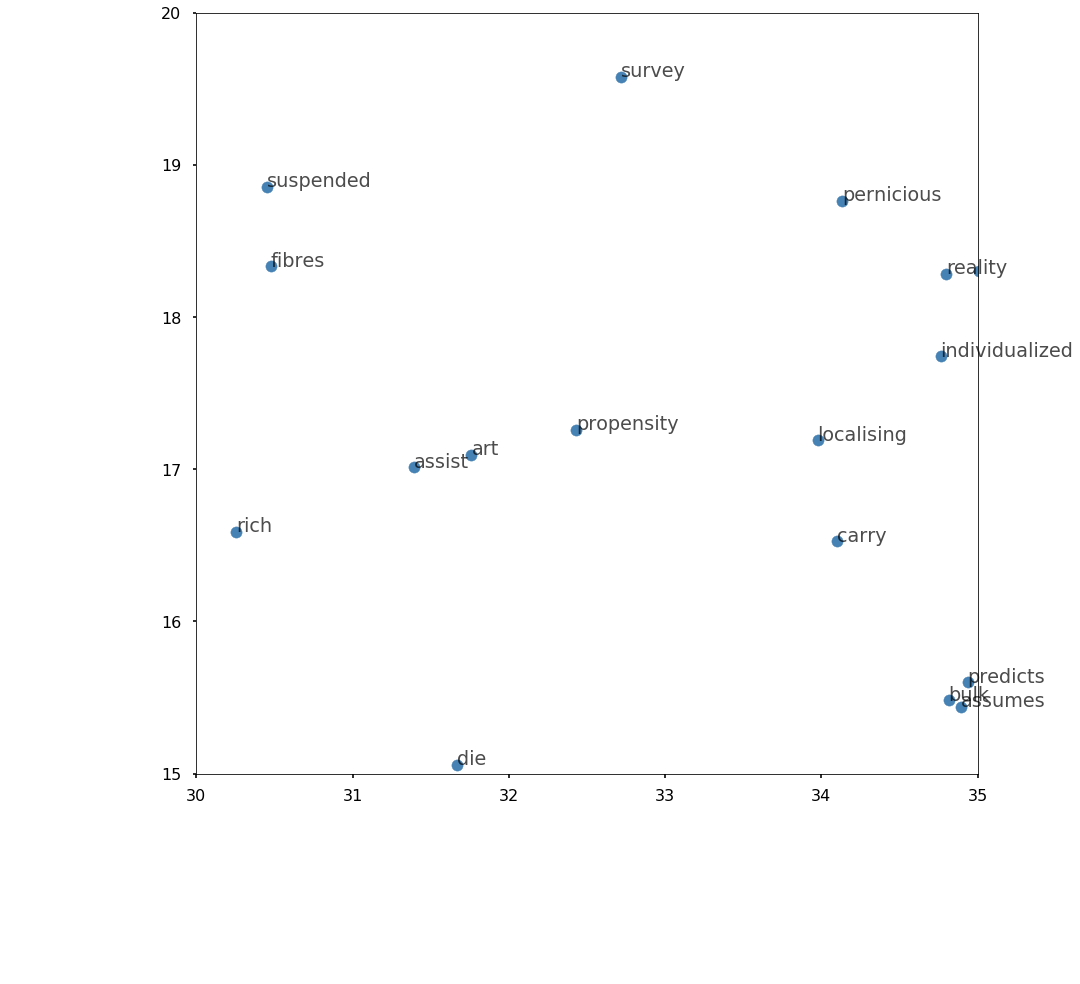

In [145]:
plt.axis([30, 35, 15, 20])
plt.show()

In [124]:
articles2vec.most_similar("gene")

[('plexus', 0.9648976922035217),
 ('Typical', 0.9571812152862549),
 ('suppressor', 0.9568175077438354),
 ('embryonal', 0.9566615223884583),
 ('genes', 0.9566161632537842),
 ('tracheobronchial', 0.9551413655281067),
 ('motor', 0.9534777998924255),
 ('Wilms', 0.9519250392913818),
 ('SCCA', 0.9509639739990234),
 ('undifferentiated', 0.9509071707725525)]

In [85]:
dictionary = corpora.Dictionary(sentences)

In [86]:
#print(dictionary.token2id)

In [87]:
corpus = [dictionary.doc2bow(sentence) for sentence in sentences]

In [88]:
corpora.MmCorpus.serialize('articles.mm', corpus)

In [37]:
#print(text)

In [38]:
text_file = open("text_file.txt", "w")
text_file.write(text)
text_file.close()

In [39]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# load id->word mapping (the dictionary), one of the results of step 2 above
id2word = dictionary
# load corpus iterator
mm = gensim.corpora.MmCorpus('articles.mm')

print(mm)



2017-10-31 14:30:15,827 : INFO : loaded corpus index from articles.mm.index
2017-10-31 14:30:15,831 : INFO : initializing corpus reader from articles.mm
2017-10-31 14:30:15,834 : INFO : accepted corpus with 2618 documents, 8324 features, 48816 non-zero entries


MmCorpus(2618 documents, 8324 features, 48816 non-zero entries)


In [42]:
lsi = gensim.models.lsimodel.LsiModel(corpus=mm, id2word=id2word, num_topics=40, chunksize=2000, distributed=True)

2017-10-31 14:31:56,333 : ERROR : failed to initialize distributed LSI (Failed to locate the nameserver)


RuntimeError: failed to initialize distributed LSI (Failed to locate the nameserver)

In [4]:
from clinical_trials import Trials

ModuleNotFoundError: No module named 'clinical_trials'